In [79]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import median_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score as acc
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras import initializers
from keras.layers import Embedding, Dense, Input, Activation, multiply, Lambda, Convolution1D, Conv2D, MaxPooling1D, MaxPooling2D, GRU, Bidirectional,TimeDistributed, Flatten, concatenate, Dropout, Reshape, concatenate, Add
from keras.layers.recurrent import LSTM
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras import regularizers
from keras.utils import plot_model

In [2]:
news = pd.read_csv('newsv1.csv')

In [3]:
news.head()

,Date,Title
0,2006-10-20,"Hey buddy, can you spare $600 for a Google share?"
1,2006-10-20,Exxon Mobil offers plan to end Alaska dispute.
2,2006-10-21,AOL CEO says sales may shrink for two years -p...
3,2006-10-22,EU to urge China to open economy further.
4,2006-10-22,"Fed to keep hawkish tone, hold rates steady."


In [4]:
news = news.sort_values(["Date"],ascending=True, inplace=False).reset_index(drop=True)

In [5]:
news.head()

,Date,Title
0,2006-10-20,"Hey buddy, can you spare $600 for a Google share?"
1,2006-10-20,"Inco's Net Soars on Higher Metal Prices, Break..."
2,2006-10-20,Exxon Mobil offers plan to end Alaska dispute.
3,2006-10-21,AOL CEO says sales may shrink for two years -p...
4,2006-10-21,"Jim Cramer: Diageo, Anheuser-Busch, Monster Wo..."


In [6]:
news.tail()

,Date,Title
554257,2013-11-26,Roederer Cristal ’04 Champagne Maintains Recor...
554258,2013-11-26,Hong Kong Short Selling Turnover Recorded 11/2...
554259,2013-11-26,Copper Falls From Two-Week High on Outlook for...
554260,2013-11-26,Toshiba to Supply Energy Storage System for To...
554261,2013-11-26,Rebar Rises in Shanghai on More Signs Output W...


In [7]:
news.shape

(554262, 2)

In [8]:
sp = pd.read_csv('^GSPC.csv')

In [9]:
sp.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2006-10-20,1366.939941,1368.660034,1362.099976,1368.599976,1368.599976,2526410000
1,2006-10-23,1368.579956,1377.400024,1363.939941,1377.020020,1377.020020,2480430000
2,2006-10-24,1377.020020,1377.780029,1372.420044,1377.380005,1377.380005,2876890000
3,2006-10-25,1377.359985,1383.609985,1376.000000,1382.219971,1382.219971,2953540000
4,2006-10-26,1382.209961,1389.449951,1379.469971,1389.079956,1389.079956,2793350000


In [10]:
sp.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1783,2013-11-20,1789.589966,1795.729980,1777.229980,1781.369995,1781.369995,3109140000
1784,2013-11-21,1783.520020,1797.160034,1783.520020,1795.849976,1795.849976,3256630000
1785,2013-11-22,1797.209961,1804.839966,1794.699951,1804.760010,1804.760010,3055140000
1786,2013-11-25,1806.329956,1808.099976,1800.579956,1802.479980,1802.479980,2998540000
1787,2013-11-26,1802.869995,1808.420044,1800.770020,1802.750000,1802.750000,3427120000


In [11]:
sp.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [12]:
news.isnull().sum()

Date     0
Title    0
dtype: int64

In [13]:
# Compare the number of unique dates. We want matching values.
print(len(set(sp.Date)))
print(len(set(news.Date)))

1788
2595


In [14]:
# Remove the extra dates that are in news
news = news[news.Date.isin(sp.Date)]

In [15]:
print(len(set(sp.Date)))
print(len(set(news.Date)))

1788
1788


In [16]:
# Calculate the rise in percent of opening stock values : Rise_Percent(t) = Open_Price(t + 1) − Open_Price(t) / Open_Price(t)
# The model will try to predict the class of rise percent
# For now we only work with two classes, UP (1) and DOWN (0)
#sp = sp.set_index('Date').diff(periods=1)
#sp = sp.set_index('Date')
sp['Rise'] = sp.Open.pct_change(axis=0)
#sp['Date'] = sp.index
#sp = sp.reset_index(drop=True)
# Remove unneeded features
sp = sp.drop(['High','Low','Close','Volume','Adj Close'], 1)

In [17]:
sp.head()

,Date,Open,Rise
0,2006-10-20,1366.939941,NaN
1,2006-10-23,1368.579956,0.001200
2,2006-10-24,1377.020020,0.006167
3,2006-10-25,1377.359985,0.000247
4,2006-10-26,1382.209961,0.003521


In [18]:
sp.tail()

,Date,Open,Rise
1783,2013-11-20,1789.589966,-0.000670
1784,2013-11-21,1783.520020,-0.003392
1785,2013-11-22,1797.209961,0.007676
1786,2013-11-25,1806.329956,0.005075
1787,2013-11-26,1802.869995,-0.001915


In [19]:
sp.isnull().sum()

Date    0
Open    0
Rise    1
dtype: int64

In [20]:
# Shift Open column up by one
sp['Rise'] = sp['Rise'].shift(-1)
#sp['Open'] = sp['Open'].shift(-1)

In [21]:
sp.head()

,Date,Open,Rise
0,2006-10-20,1366.939941,0.001200
1,2006-10-23,1368.579956,0.006167
2,2006-10-24,1377.020020,0.000247
3,2006-10-25,1377.359985,0.003521
4,2006-10-26,1382.209961,0.004833


In [22]:
sp.tail()

,Date,Open,Rise
1783,2013-11-20,1789.589966,-0.003392
1784,2013-11-21,1783.520020,0.007676
1785,2013-11-22,1797.209961,0.005075
1786,2013-11-25,1806.329956,-0.001915
1787,2013-11-26,1802.869995,NaN


In [23]:
# Remove row since it has a null value.
sp = sp[sp.Rise.notnull()]
#sp = sp[sp.Open.notnull()]

In [24]:
sp.head()

,Date,Open,Rise
0,2006-10-20,1366.939941,0.001200
1,2006-10-23,1368.579956,0.006167
2,2006-10-24,1377.020020,0.000247
3,2006-10-25,1377.359985,0.003521
4,2006-10-26,1382.209961,0.004833


In [25]:
sp.tail()

,Date,Open,Rise
1782,2013-11-19,1790.790039,-0.000670
1783,2013-11-20,1789.589966,-0.003392
1784,2013-11-21,1783.520020,0.007676
1785,2013-11-22,1797.209961,0.005075
1786,2013-11-25,1806.329956,-0.001915


In [26]:
# Check if there are any more null values.
sp.isnull().sum()

Date    0
Open    0
Rise    0
dtype: int64

In [27]:
#sp.drop(['Class'], axis = 1) 

In [28]:
# Divide Rise into two classes (1 and 0). If rise>=0.0012, rise = 1 else rise = 0[Positive - 1, Negative - 0]
sp['Class'] = sp.Rise.apply(lambda x: 1 if x >= 0.0012 else 0)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f20082ff890>]],
      dtype=object)

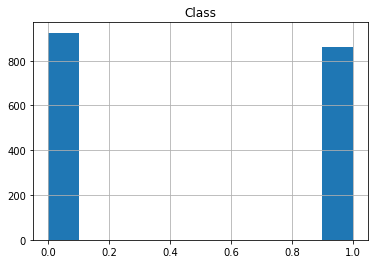

In [29]:
sp.hist(column='Class')

In [30]:
sp.shape

(1787, 4)

In [31]:
sp.head()

,Date,Open,Rise,Class
0,2006-10-20,1366.939941,0.001200,0
1,2006-10-23,1368.579956,0.006167,1
2,2006-10-24,1377.020020,0.000247,0
3,2006-10-25,1377.359985,0.003521,1
4,2006-10-26,1382.209961,0.004833,1


In [32]:
# input_time_step = 5
# output_time_step = 1 #Always one since we are only predicting for next day
# in_start = 0
# past = []
# for i in range(len(sp)):
#     in_end = in_start + input_time_step
#     #out_end = in_end + output_time_step
#     if (in_end+1) <= len(sp):
#         past.append(sp.iloc[in_start+1:in_end+1, 1].values)
#     in_start += 1
# #x_train, y_train = np.array(x_train), np.array(y_train)
# #x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# print(len(past))
# print(len(sp))
# #print(y_train.shape)

In [33]:
#[past.pop(i[0]) for i in past]

In [34]:
#past[0]

In [35]:
# #sp = sp.drop(['Past'], axis = 1) 
# sp.insert(4,'Past', pd.Series(past))
# #sp.head()

In [36]:
#sp.head()

In [37]:
#sp.tail(10)

In [38]:
# # Shift by the number of input time step
# sp['Past'] = sp['Past'].shift(input_time_step)

In [39]:
#sp.head(8)

In [40]:
#sp.tail()

In [41]:
#sp.get_value(5, 'Past') 

In [42]:
#sp = sp[sp.Past.notnull()]

In [43]:
#sp.head()

In [44]:
#sp.tail()

In [45]:
#sp.get_value(6, 'Past') 

In [46]:
#sp.shape

In [47]:
# Create a list of the change in opening prices and their corresponding daily headlines from the news that caused that change
move = []
headlines = []

for row in sp.iterrows():
    daily_headlines = []
    date = row[1]['Date']
    move.append(row[1]['Class'])
    for row_ in news[news.Date==date].iterrows():
        daily_headlines.append(row_[1]['Title'])
    
    # Track progress
    headlines.append(daily_headlines)
    if len(move) % 500 == 0:
        print(len(move))

500
1000
1500


In [48]:
print(move[0])

0


In [49]:
len(move)

1787

In [50]:
#headlines[:5]
headlines[0]

['Hey buddy, can you spare $600 for a Google share?',
 "Inco's Net Soars on Higher Metal Prices, Breakup Fee.",
 'Exxon Mobil offers plan to end Alaska dispute.']

In [51]:
#check
#news[news['Date']=='2006-10-27']

In [52]:
#len(news[news['Date'] == '2006-10-23'])

In [53]:
# Compare lengths to ensure they are the same
print(len(move))
print(len(headlines))
#print(len(past))

1787
1787


In [54]:
# Compare the number of headlines for each day
print(max(len(i) for i in headlines))
print(min(len(i) for i in headlines))
#print(np.mean(len(i) for i in headlines))

1572
3


In [55]:
# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [56]:
import string
def clean_text(text, remove_stopwords = True):
    '''Remove unwanted characters and format the text to create fewer nulls word embeddings'''
    
    # Convert words to lower case
    text = text.lower()
    
    # Replace contractions with their longer forms 
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
        
    if '-' in text and 'update' in text:
        text = text[text.find('-') + 1:]
    
    # Format words and remove unwanted characters
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'0,0', '00', text) 
    #text = re.sub(r'[_"\-;%()|.,+&=*%.,!?:#@\[\]$]', '', text)
    text = re.sub(r'\'', ' ', text)
    #text = re.sub(r'\$', ' $ ', text)
    text = re.sub(r'u s ', ' united states ', text)
    text = re.sub(r'u n ', ' united nations ', text)
    text = re.sub(r'u k ', ' united kingdom ', text)
    text = re.sub(r'j k ', ' jk ', text)
    text = re.sub(r' s ', ' ', text)
    text = re.sub(r' yr ', ' year ', text)
    text = re.sub(r' l g b t ', ' lgbt ', text)
    text = re.sub(r'0km ', '0 km ', text)
    
    text = text.translate(str.maketrans('','',string.punctuation))
    
    # Optionally, remove stop words
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    return text

In [57]:
# Clean the headlines
clean_headlines = []

for daily_headlines in headlines:
    clean_daily_headlines = []
    for headline in daily_headlines:
        clean_daily_headlines.append(clean_text(headline))
    clean_headlines.append(clean_daily_headlines)

In [58]:
# Take a look at some headlines to ensure everything was cleaned well
clean_headlines[0]

['hey buddy spare 600 google share',
 'inco net soars higher metal prices breakup fee',
 'exxon mobil offers plan end alaska dispute']

In [59]:
len(clean_headlines)

1787

In [60]:
# Find the number of times each word was used and the size of the vocabulary
word_counts = {}

for date in clean_headlines:
    for headline in date:
        for word in headline.split():
            if word not in word_counts:
                word_counts[word] = 1
            else:
                word_counts[word] += 1
            
print("Size of Vocabulary:", len(word_counts))

Size of Vocabulary: 116488


In [61]:
#word_counts['hey']

In [62]:
# Load Word2Vec model (trained on an enormous Google corpus)
#embeddings_index = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary = True)

In [63]:
# Load GloVe's embeddings
embeddings_index = {}
with open('glove.840B.300d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = embedding

print('Word embeddings:', len(embeddings_index))

Word embeddings: 2196016


In [64]:
# Find the number of words that are missing from GloVe, and are used more than our threshold.
missing_words = 0
threshold = 10

for word, count in word_counts.items():
    if count > threshold:
        if word not in embeddings_index:
            missing_words += 1
            
missing_ratio = round(missing_words/len(word_counts),4)*100
            
print("Number of words missing from GloVe:", missing_words)
print("Percent of words that are missing from vocabulary: {}%".format(missing_ratio))

Number of words missing from GloVe: 3533
Percent of words that are missing from vocabulary: 3.0300000000000002%


In [65]:
# Limit the vocab that we will use to words that appear ≥ threshold or are in GloVe

#dictionary to convert words to integers
vocab_to_int = {} 

value = 0
for word, count in word_counts.items():
    if count >= threshold or word in embeddings_index:
        vocab_to_int[word] = value
        value += 1

# Special tokens that will be added to our vocab
codes = ["<UNK>","<PAD>"]   

# Add codes to vocab
for code in codes:
    vocab_to_int[code] = len(vocab_to_int)

# Dictionary to convert integers to words
int_to_vocab = {}
for word, value in vocab_to_int.items():
    int_to_vocab[value] = word

usage_ratio = round(len(vocab_to_int) / len(word_counts),4)*100

print("Total Number of Unique Words:", len(word_counts))
print("Number of Words we will use:", len(vocab_to_int))
print("Percent of Words we will use: {}%".format(usage_ratio))

Total Number of Unique Words: 116488
Number of Words we will use: 65519
Percent of Words we will use: 56.25%


In [66]:
# Need to use 300 for embedding dimensions to match GloVe's vectors.
embedding_dim = 300

nb_words = len(vocab_to_int)
# Create matrix with default values of zero
word_embedding_matrix = np.zeros((nb_words, embedding_dim))
for word, i in vocab_to_int.items():
    if word in embeddings_index:
        word_embedding_matrix[i] = embeddings_index[word]
    else:
        # If word not in GloVe, create a random embedding for it
        new_embedding = np.array(np.random.uniform(-1.0, 1.0, embedding_dim))
        embeddings_index[word] = new_embedding
        word_embedding_matrix[i] = new_embedding

# Check if value matches len(vocab_to_int)
print(len(word_embedding_matrix))

65519


In [67]:
# Change the text from words to integers
# If word is not in vocab, replace it with <UNK> (unknown)
word_count = 0
unk_count = 0

int_headlines = []

for date in clean_headlines:
    int_daily_headlines = []
    for headline in date:
        int_headline = []
        for word in headline.split():
            word_count += 1
            if word in vocab_to_int:
                int_headline.append(vocab_to_int[word])
            else:
                int_headline.append(vocab_to_int["<UNK>"])
                unk_count += 1
        int_daily_headlines.append(int_headline)
    int_headlines.append(int_daily_headlines)

unk_percent = round(unk_count/word_count,4)*100

print("Total number of words in headlines:", word_count)
print("Total number of UNKs in headlines:", unk_count)
print("Percent of words that are UNK: {}%".format(unk_percent))

Total number of words in headlines: 3919392
Total number of UNKs in headlines: 89870
Percent of words that are UNK: 2.29%


In [68]:
int_headlines[0]

[[0, 1, 2, 3, 4, 5],
 [6, 7, 8, 9, 10, 11, 12, 13],
 [14, 15, 16, 17, 18, 19, 20]]

In [69]:
# Find the length of headlines
lengths = []
for date in int_headlines:
    for headline in date:
        lengths.append(len(headline))

# Create a dataframe so that the values can be inspected
lengths = pd.DataFrame(lengths, columns=['counts'])

In [70]:
lengths.describe()

,counts
count,500744.000000
mean,7.827137
std,1.447765
min,0.000000
25%,7.000000
50%,8.000000
75%,9.000000
max,15.000000


In [71]:
# Limit the length of a day's news to 200 words, and the length of any headline to 15 words.
# These values are chosen to not have an excessively long training time and 
# balance the number of headlines used and the number of words from each headline.
max_headline_length = 15
max_daily_length = 200
pad_headlines = []

for date in int_headlines:
    pad_daily_headlines = []
    for headline in date:
        # Add headline if it is less than max length
        if len(headline) <= max_headline_length:
            for word in headline:
                pad_daily_headlines.append(word)
        # Limit headline if it is more than max length  
        else:
            headline = headline[:max_headline_length]
            for word in headline:
                pad_daily_headlines.append(word)
    
    # Pad daily_headlines if they are less than max length
    if len(pad_daily_headlines) < max_daily_length:
        for i in range(max_daily_length-len(pad_daily_headlines)):
            pad = vocab_to_int["<PAD>"]
            pad_daily_headlines.append(pad)
    # Limit daily_headlines if they are more than max length
    else:
        pad_daily_headlines = pad_daily_headlines[:max_daily_length]
    pad_headlines.append(pad_daily_headlines)

In [72]:
pad_headlines[0]

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 65518,
 

In [73]:
# Split data into training and testing sets.
# Validating data will be created during training.
x_train, x_test, y_train, y_test = train_test_split(pad_headlines, move, test_size = 0.15, random_state = 2)

x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [75]:
zero_train = np.count_nonzero(y_train == 0)
zero_test = np.count_nonzero(y_test == 0)
one_train = np.count_nonzero(y_train == 1)
one_test = np.count_nonzero(y_test == 1)
print(zero_train)
print(zero_test)
print(one_train)
print(one_test)

796
129
722
140


In [76]:
# Check the lengths
print(len(x_train))
print(len(x_test))

1518
269


In [83]:
filter_length1 = 3
filter_length2 = 5
dropout = 0.5
learning_rate = 0.001
weights = initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=2)
nb_filter = 16
rnn_output_size = 128
hidden_dims = 128
wider = True
deeper = True

if wider == True:
    nb_filter *= 2
    rnn_output_size *= 2
    hidden_dims *= 2
    

def build_model():
    
    model1 = Sequential()
    
    model1.add(Embedding(nb_words, 
                         embedding_dim,
                         weights=[word_embedding_matrix], 
                         input_length=max_daily_length))
    model1.add(Dropout(dropout))
    
    model1.add(Convolution1D(filters = nb_filter, 
                             kernel_size = filter_length1, 
                             padding = 'same',
                            activation = 'relu'))
    model1.add(Dropout(dropout))
    
    if deeper == True:
        model1.add(Convolution1D(filters = nb_filter, 
                                 kernel_size = filter_length1, 
                                 padding = 'same',
                                activation = 'relu'))
        model1.add(Dropout(dropout))
    
    model1.add(LSTM(rnn_output_size, 
                   activation=None,
                   kernel_initializer=weights,
                   dropout = dropout))
    
    ####
    
    model2 = Sequential()
    
    model2.add(Embedding(nb_words, 
                         embedding_dim,
                         weights=[word_embedding_matrix], 
                         input_length=max_daily_length))
    model2.add(Dropout(dropout))
    
    
    model2.add(Convolution1D(filters = nb_filter, 
                             kernel_size = filter_length2, 
                             padding = 'same',
                             activation = 'relu'))
    model2.add(Dropout(dropout))
    
    if deeper == True:
        model2.add(Convolution1D(filters = nb_filter, 
                                 kernel_size = filter_length2, 
                                 padding = 'same',
                                 activation = 'relu'))
        model2.add(Dropout(dropout))
    
    model2.add(LSTM(rnn_output_size, 
                    activation=None,
                    kernel_initializer=weights,
                    dropout = dropout))
    
    ####
    model = Sequential()

    model = Add()([model1.output, model2.output])
    
    model = Dense(hidden_dims, kernel_initializer=weights)(model)
    model = Dropout(dropout)(model)
    
    if deeper == True:
        model = Dense(hidden_dims//2, kernel_initializer=weights)(model)
        model = Dropout(dropout)(model)

    model = Dense(1, kernel_initializer = weights, name='output', activation='softmax')(model)
    new_model = Model([model1.input, model2.input], model)
    new_model.compile(loss='binary_crossentropy',
                  optimizer=Adam(lr=learning_rate,clipvalue=1.0),
                  metrics=['accuracy'])
    return new_model

In [84]:
model = build_model()
#|plot_model(model,show_shapes=True)

In [ ]:
# Use grid search to help find a better model
for deeper in [False]:
    for wider in [True,False]:
        for learning_rate in [0.001]:
            for dropout in [0.3, 0.5]:
                model = build_model()
                print()
                print("Current model: Deeper={}, Wider={}, LR={}, Dropout={}".format(
                    deeper,wider,learning_rate,dropout))
                print()
                save_best_weights = 'question_pairs_weights_deeper={}_wider={}_lr={}_dropout={}.h5'.format(
                    deeper,wider,learning_rate,dropout)

                callbacks = [ModelCheckpoint(save_best_weights, monitor='val_loss', save_best_only=True),
                             EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto'),
                             ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=3)]

                history = model.fit([x_train,x_train],
                                    y_train,
                                    batch_size=32,
                                    epochs=100,
                                    validation_split=0.15,
                                    verbose=True,
                                    shuffle=True,
                                    callbacks = callbacks)


Current model: Deeper=False, Wider=True, LR=0.001, Dropout=0.3



/home/saugat/anaconda3/envs/research/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1290 samples, validate on 228 samples
Epoch 1/100
1290/1290 [==============================] - 107s 83ms/step - loss: 8.0113 - accuracy: 0.4775 - val_loss: 8.2046 - val_accuracy: 0.4649
Epoch 2/100
1290/1290 [==============================] - 54s 42ms/step - loss: 8.0113 - accuracy: 0.4775 - val_loss: 8.2046 - val_accuracy: 0.4649
Epoch 3/100
1290/1290 [==============================] - 55s 42ms/step - loss: 8.0113 - accuracy: 0.4775 - val_loss: 8.2046 - val_accuracy: 0.4649
Epoch 4/100
1290/1290 [==============================] - 58s 45ms/step - loss: 8.0113 - accuracy: 0.4775 - val_loss: 8.2046 - val_accuracy: 0.4649

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 5/100
1290/1290 [==============================] - 57s 45ms/step - loss: 8.0113 - accuracy: 0.4775 - val_loss: 8.2046 - val_accuracy: 0.4649
Epoch 6/100
1290/1290 [==============================] - 56s 43ms/step - loss: 8.0113 - accuracy: 0.4775 - val_loss: 8.2046 - val_accur

/home/saugat/anaconda3/envs/research/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1290 samples, validate on 228 samples
Epoch 1/100
1024/1290 [======================>.......] - ETA: 23s - loss: 7.8912 - accuracy: 0.4854

In [76]:
#news.groupby('Date').count().sort_values('Title')
news_group = news.groupby('Date').count()
#news_group.apply()

In [77]:
#(headlines_vector[347])
news_group.head()

,Title
Date,
2006-10-20,3
2006-10-23,36
2006-10-24,43
2006-10-25,30
2006-10-26,40


In [79]:
news_group.shape

(1788, 1)

In [83]:
news_group.loc[news_group['Title'] < 25]

,Title
Date,
2006-10-20,3
2006-12-26,20
2007-12-26,18
2008-12-26,23
2009-12-18,19
2009-12-22,24
2009-12-24,22


In [157]:
#Try
daily_num_news = 25
embed_dim = 300

headlines_vector_padded = []
#i=0
for date in headlines_vector:
    #print(np.array(date).shape)
    #print(i)
    #i = i+1
    news_vector_padded = []
    if(len(date)) < daily_num_news:
        padding_num = daily_num_news - len(date)
        news_vector_padded = np.vstack((date, ([np.zeros(embed_dim)] * padding_num)))
        #news_vector_padded.append(date + ([np.zeros(300)] * padding_num))
        #news_vector_padded.append([np.zeroes(300)] * padding_num)
    else:
        #news_vector_padded.append(date[:daily_num_news])
        news_vector_padded = np.vstack(d for d in date[:daily_num_news])
    #print(news_vector_padded)    
    headlines_vector_padded.append(news_vector_padded)
    #headlines_vector_padded.append(news_vector_padded[np.newaxis, :])
    #headlines_vector_padded = np.vstack(news_vector_padded)

/home/saugat/.local/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


In [160]:
np.array(headlines_vector_padded[1]).shape

(25, 300)

In [161]:
headlines_vector_padded[0]

array([[-0.13567515,  0.2628863 ,  0.1944786 , ..., -0.14638028,
         0.19626315,  0.23674856],
       [-0.7025201 ,  0.32160696,  0.15189333, ..., -0.20395498,
         0.16223966, -0.31123665],
       [-0.05533125,  0.22471303, -0.22598514, ..., -0.13654289,
         0.194108  ,  0.09083587],
       ...,
       [-0.5621803 ,  0.3642314 ,  0.02979171, ..., -0.14498343,
         0.16493244,  0.12152786],
       [ 0.037502  ,  0.12575525, -0.10482925, ..., -0.23934749,
         0.15329999,  0.13415374],
       [-0.13152575,  0.26045835,  0.00208455, ...,  0.03002288,
        -0.04087337, -0.17026688]], dtype=float32)

In [162]:
len(headlines_vector_padded)

1782

In [163]:
len(move)

1782

In [164]:
len(past)

1782

In [165]:
# split into train, validation and test sets
train_size = int(len(move) * 0.8)
print(train_size)
val_size = int(len(move) * 0.1)
print(val_size)
test_size = int(len(move) * 0.1)
print(test_size)

1425
178
178


In [166]:
# News Data
x_train_headlines = headlines_vector_padded[:train_size]
x_val_headlines = headlines_vector_padded[train_size:(train_size+val_size)]
x_test_headlines = headlines_vector_padded[(train_size+val_size):len(headlines_vector_padded)]

# Technical Data
x_train_past = past[:train_size]
x_val_past = past[train_size:(train_size+val_size)]
x_test_past = past[(train_size+val_size):len(past)]

# Output
y_train_move = move[:train_size]
y_val_move = move[train_size:(train_size+val_size)]
y_test_move = move[(train_size+val_size):len(move)]

In [168]:
np.array(x_test_headlines).shape

(179, 25, 300)

In [169]:
from sklearn.preprocessing import MinMaxScaler
scaler_past = MinMaxScaler()

In [170]:
# Scale the train dataset (Fit and transform)
x_train_past_norm = scaler_past.fit_transform(x_train_past)

In [171]:
# Scale val/test dataset(transform only)
x_test_past_norm = scaler_past.transform(x_test_past)
x_val_past_norm = scaler_past.transform(x_val_past)

In [172]:
# Reshape historical data for LSTM
x_train_past_norm = np.reshape(x_train_past_norm, (x_train_past_norm.shape[0], input_time_step, 1))
x_val_past_norm = np.reshape(x_val_past_norm, (x_val_past_norm.shape[0], input_time_step, 1))
x_test_past_norm = np.reshape(x_test_past_norm, (x_test_past_norm.shape[0], input_time_step, 1))
print(x_train_past_norm.shape)
print(x_val_past_norm.shape)
print(x_test_past_norm.shape)

(1425, 5, 1)
(178, 5, 1)
(179, 5, 1)


In [173]:
x_train_headlines = np.array(x_train_headlines)
x_val_headlines = np.array(x_val_headlines)
x_test_headlines = np.array(x_test_headlines)

In [174]:
x_train_headlines.shape

(1425, 25, 300)

In [175]:
#y_train_move

In [176]:
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Activation, multiply, Lambda, Convolution1D, Conv2D, MaxPooling1D, MaxPooling2D, GRU, Bidirectional,TimeDistributed, Flatten, concatenate, Dropout, Reshape
from keras.layers.recurrent import LSTM
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam, SGD, RMSprop
from keras import regularizers, initializers
from keras import backend as K
from keras.utils import plot_model
#from tcn import TCN
from keract import get_activations

In [194]:
rnn_output_size = 128
hidden_dims = 128
n_grams = [3,4,5]
filters = 64
num_dense_layers = 3

def news_branch():
    # Input for one day : max article per day, dim_vec=embed_dim
    input1 = Input(shape=(daily_num_news, embed_dim))
    
    #reshape_input = Reshape((daily_num_news, embed_dim, 1))(input1)
    
    merged_layer = []
    
    for h in n_grams:
        conv_layer = Convolution1D(filters, h, activation='relu',padding = 'valid')(input1)
        pool_layer = MaxPooling1D(pool_size=(daily_num_news-h+1))(conv_layer)
        merged_layer.append(pool_layer)
    
    concat_layer = concatenate(merged_layer)
    flatten_layer = Flatten()(concat_layer)
    in_ = flatten_layer
    prev_units = filters * len(n_grams)
    
    for _ in range(num_dense_layers - 1):
        prev_units //= 2
        dense_layer = Dense(prev_units,
                            activation='relu', 
                            kernel_regularizer = regularizers.l2(0.01))(in_)
        
        drop_layer = Dropout(0.5)(dense_layer)
        in_ = drop_layer
   
    model = Model(inputs = input1, outputs = in_)
    return model

In [195]:
def technical_branch():
    
    model = Sequential()
    
    model.add(LSTM(100, input_shape=(None, 1)))
    model.add(Dense(48, activation='relu'))
    
    return model

In [196]:
# create the news and technical branch
news_model = news_branch()
technical_model = technical_branch()

# create the input to our final set of layers as the *output* of both news and technical layer
combinedInput = concatenate([news_model.output, technical_model.output])

# our final FC layer head will have two dense layers, the final one being our regression head
x = Dense(32, activation="relu")(combinedInput) #model.add(Dense(hidden_dims//2, kernel_initializer=weights))
# Dropout 
x = Dropout(0.5)(x)
x = Dense(1, activation="sigmoid")(x)

# our final model will accept tecnical/historical data on the technical branch input and 
# news events(embeddings) on news branch input, outputting a single value (the predicted opening price change)
model = Model(inputs=[news_model.input, technical_model.input], outputs=x)
#model.summary()
# plot graph
#plot_model(model,show_shapes=True,to_file='combined_model.png')

# Compiling the model
learning_rate = 0.01
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=learning_rate,clipvalue=1.0),
              metrics=['accuracy'])

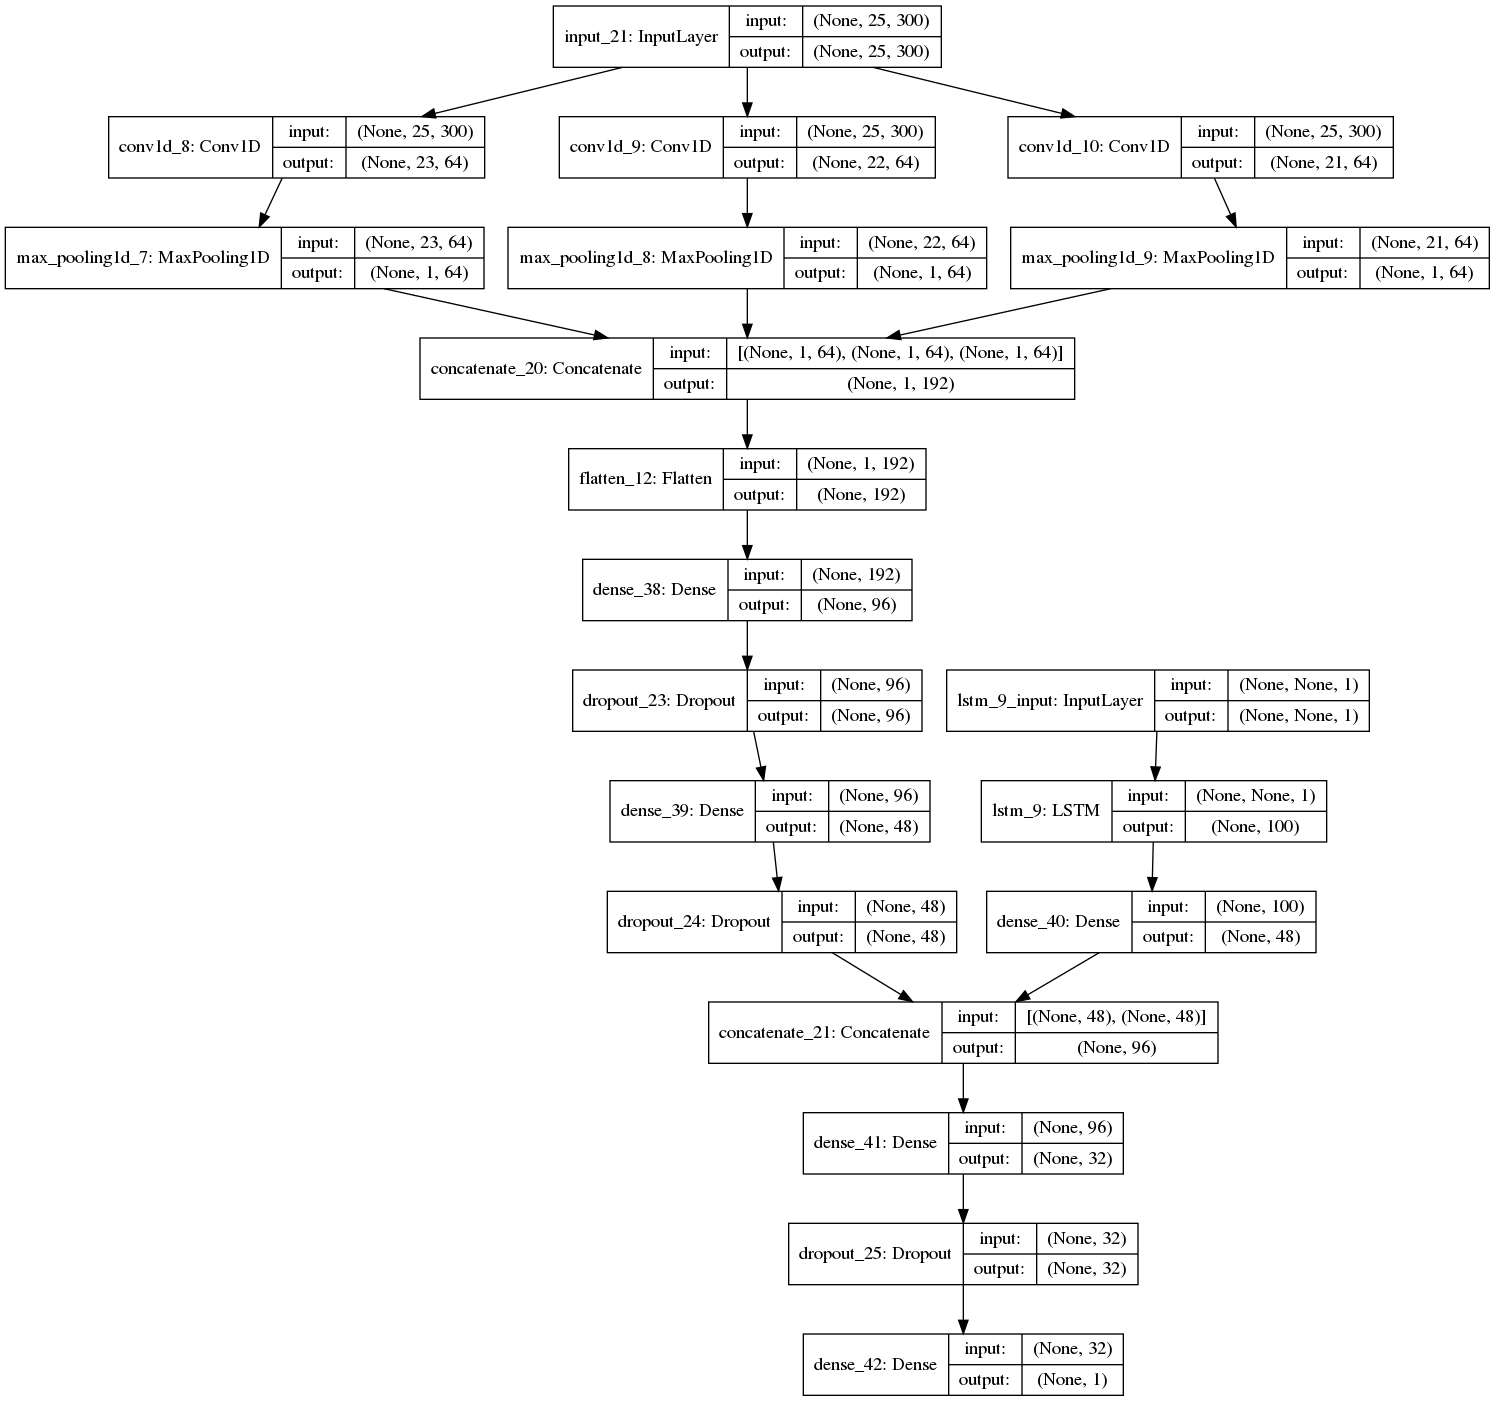

In [197]:
plot_model(model,show_shapes=True)

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', patience=30, verbose=1, mode='auto'),
             ModelCheckpoint(filepath='han_combined.h5', monitor='val_loss', save_best_only=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=10)]

# history = model.fit(x_train_headlines,
#                     y_train_move,
#                     batch_size=32,
#                     epochs=100,
#                     validation_data=(x_val_headlines, y_val_move),
#                     verbose=True)


history = model.fit([x_train_headlines, x_train_past_norm],
                    y_train_move,
                    batch_size=32,
                    epochs=100,
                    validation_data=([x_val_headlines, x_val_past_norm], y_val_move),
                    verbose=True)
#callbacks = callbacks

Train on 1425 samples, validate on 178 samples
Epoch 1/100
1425/1425 [==============================] - 3s 2ms/step - loss: 1.1014 - accuracy: 0.5123 - val_loss: 0.7394 - val_accuracy: 0.5730
Epoch 2/100
1425/1425 [==============================] - 1s 606us/step - loss: 0.7170 - accuracy: 0.5151 - val_loss: 0.6909 - val_accuracy: 0.5730
Epoch 3/100
1425/1425 [==============================] - 1s 603us/step - loss: 0.6972 - accuracy: 0.5186 - val_loss: 0.6903 - val_accuracy: 0.5730
Epoch 4/100
1425/1425 [==============================] - 1s 619us/step - loss: 0.6934 - accuracy: 0.5186 - val_loss: 0.6903 - val_accuracy: 0.5730
Epoch 5/100
1425/1425 [==============================] - 1s 609us/step - loss: 0.6928 - accuracy: 0.5186 - val_loss: 0.6872 - val_accuracy: 0.5730
Epoch 6/100
1425/1425 [==============================] - 1s 610us/step - loss: 0.6928 - accuracy: 0.5186 - val_loss: 0.6884 - val_accuracy: 0.5730
Epoch 7/100
1425/1425 [==============================] - 1s 636us/step - 

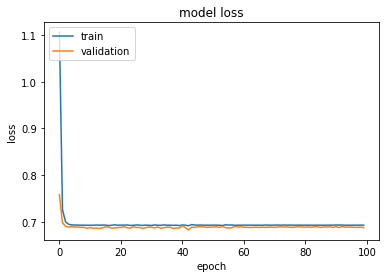

In [182]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

In [113]:
predictions = model.predict([x_test_headlines, x_test_diff_norm], verbose = True)

179/179 [==============================] - 0s 609us/step


In [183]:
#plot_model(attention_model,show_shapes=True,to_file='attention_model.png')

In [175]:
from sklearn.metrics import median_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score as acc

In [176]:
# Compare test values and predictions
mse(y_test_price_norm, predictions)

0.004392879282451214

In [177]:
unnorm_predictions = scaler_price.inverse_transform(predictions)
unnorm_y_test = scaler_price.inverse_transform(y_test_price_norm.reshape(-1,1))

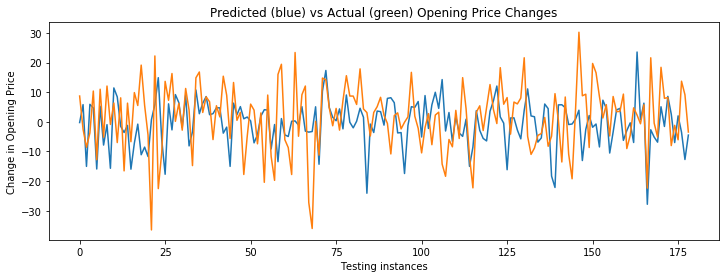

In [178]:
plt.figure(figsize=(12,4))
plt.plot(unnorm_predictions)
plt.plot(unnorm_y_test)
plt.title("Predicted (blue) vs Actual (green) Opening Price Changes")
plt.xlabel("Testing instances")
plt.ylabel("Change in Opening Price")
plt.show()

In [179]:
# Create lists to measure if opening price increased or decreased
direction_pred = []
for pred in unnorm_predictions:
    if pred >= 0:
        direction_pred.append(1)
    else:
        direction_pred.append(0)
direction_test = []
for value in unnorm_y_test:
    if value >= 0:
        direction_test.append(1)
    else:
        direction_test.append(0)

In [180]:
# Calculate if the predicted direction matched the actual direction
direction = acc(direction_test, direction_pred)
direction = round(direction,4)*100
print("Predicted values matched the actual direction {}% of the time.".format(direction))

Predicted values matched the actual direction 58.099999999999994% of the time.


In [181]:
# Calculate the median absolute error for the predictions
mae(unnorm_y_test, unnorm_predictions)

7.682060538574433

In [182]:
mse(unnorm_y_test, unnorm_predictions)

162.80035648390208